In [1]:
import matplotlib.pyplot as plt
import torch.sparse as sp
from scipy.sparse import lil_matrix
import torch
from paramets import *
# import json
from tqdm import tqdm

## Rewrite the original code using torch

In [2]:
# Ng, Tf = 64, 10001

def laplacian(n):
    # Total number of grid points
    total_points = n * n

    matrix_laplacian = lil_matrix((total_points, total_points))
    
    # Fill the matrix based on finite difference method for Laplacian
    for i in range(n):
        for j in range(n):
            row = i * n + j  # Current grid point
            
            # Diagonal element
            matrix_laplacian[row, row] = 4
            
            # Check and update neighbors (left, right, up, down)
            if i > 0:
                matrix_laplacian[row, (i - 1) * n + j] = -1  # Up
            if i < n - 1:
                matrix_laplacian[row, (i + 1) * n + j] = -1  # Down
            if j > 0:
                matrix_laplacian[row, i * n + (j - 1)] = -1  # Left
            if j < n - 1:
                matrix_laplacian[row, i * n + (j + 1)] = -1  # Right
    
    # Convert to CSR format for efficient arithmetic operations
    
    matrix_laplacian = matrix_laplacian.tocsr()
    matrix_laplacian = -matrix_laplacian

    # Extract coordinates and values
    row_indices = []
    col_indices = []
    values = []

    for row in range(matrix_laplacian.shape[0]):
        start = matrix_laplacian.indptr[row]
        end = matrix_laplacian.indptr[row + 1]
        row_indices.extend([row] * (end - start))
        col_indices.extend(matrix_laplacian.indices[start:end])
        values.extend(matrix_laplacian.data[start:end])
    
    # convert to coo_matrix
    coo_matrix = torch.sparse_coo_tensor(
                torch.tensor([row_indices, col_indices], dtype=torch.int64),
                torch.tensor(values, dtype=torch.float32),
                torch.Size((n*n,n*n))
                )
    return coo_matrix

master_list = []
def integrate(L, u, T):
    '''  simulates the equation and plots it at different instants '''
    T = torch.tensor([T], device='cpu')
    for i in range(Tf.item()):
        noise = torch.normal(mean=0.0, std=1.0, size=(Ng * Ng, 1), device='cpu')
        u = u - dt * (a * u + b * u * u * u - k * torch.mm(L, u)) + torch.sqrt(2 * T * dt) * noise  # Euler's method
        if (i==10000):
            master_list.append(u)

## Calculate the mean of configurations

In [3]:
def avg_realizations(master_list, Ng):
    """ Evaluate the average over the configurations (realizations)"""
    mean_config = []
    size = len(master_list)
    N = Ng*Ng
    temp = 0
    for point in tqdm(range(N), desc="Processing", ncols=100, ascii=True):
        for config in range(size):
            temp += master_list[config][point]
        mean_config.append(temp/size)
        temp = 0
    mean_config = torch.tensor(mean_config)
    mean_config = mean_config.view((Ng, Ng))
    return mean_config

# mean_config = avg_realizations(master_list, Ng)
# plt.imshow(mean_config)
# plt.show()

In [4]:
def avg_final(mean_config, Ng):
    sum = 0 
    for x in range(Ng):
        for y in range(Ng):
            sum = sum + mean_config[x][y]
    return sum / (Ng*Ng)

# media_final(mean_config, Ng)

## RUN PIPELINE

In [5]:
# generate the grid and initialise the field

## define o dispositivo cuda a ser utilizado

device = torch.device('cpu')

x = torch.linspace(-1, 1, Ng)
y = torch.linspace(-1, 1, Ng)
X, Y = torch.meshgrid(x, y)

## simula 100 configurações finais com os parametros iniciais
L = laplacian(Ng)
L = L.to(device)         # construct the laplacian
N_real = 50

list_vev = []
for T in [0.1, 0.2, 0.3, 0.4]:
  for realization in tqdm(range(N_real), desc="Processing", ncols=100, ascii=True):
    u = torch.randn(Ng * Ng, 1, device=device)  # Initial data
    integrate(L, u, T)    # simulate
    if realization % 10 ==0:
      print(f'Realization: {realization}')

  mean_config = avg_realizations(master_list, Ng)
  VEV = avg_final(mean_config, Ng)
  list_vev.append(VEV)

d:\Anaconda\Anaconda\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Processing:   2%|#                                                   | 1/50 [00:07<06:18,  7.73s/it]

Realization: 0


Processing:  22%|###########2                                       | 11/50 [01:16<04:21,  6.70s/it]

Realization: 10


Processing:  42%|#####################4                             | 21/50 [02:28<03:27,  7.14s/it]

Realization: 20


Processing:  62%|###############################6                   | 31/50 [03:38<02:13,  7.03s/it]

Realization: 30


Processing:  82%|#########################################8         | 41/50 [04:47<01:00,  6.69s/it]

Realization: 40


Processing:   2%|#                                                   | 1/50 [00:06<05:14,  6.42s/it]

Realization: 0


Processing:  22%|###########2                                       | 11/50 [01:18<04:34,  7.05s/it]

Realization: 10


Processing:  42%|#####################4                             | 21/50 [02:29<03:28,  7.19s/it]

Realization: 20


Processing:  62%|###############################6                   | 31/50 [03:41<02:21,  7.45s/it]

Realization: 30


Processing:  82%|#########################################8         | 41/50 [04:49<00:57,  6.37s/it]

Realization: 40


Processing:   2%|#                                                   | 1/50 [00:06<05:05,  6.23s/it]

Realization: 0


Processing:  22%|###########2                                       | 11/50 [01:15<04:24,  6.78s/it]

Realization: 10


Processing:  42%|#####################4                             | 21/50 [02:32<03:36,  7.47s/it]

Realization: 20


Processing:  62%|###############################6                   | 31/50 [03:47<02:19,  7.32s/it]

Realization: 30


Processing:  82%|#########################################8         | 41/50 [05:02<01:05,  7.32s/it]

Realization: 40


Processing:   2%|#                                                   | 1/50 [00:06<05:05,  6.23s/it]

Realization: 0


Processing:  22%|###########2                                       | 11/50 [01:12<04:08,  6.37s/it]

Realization: 10


Processing:  42%|#####################4                             | 21/50 [02:20<03:19,  6.88s/it]

Realization: 20


Processing:  62%|###############################6                   | 31/50 [03:26<02:00,  6.36s/it]

Realization: 30


Processing:  82%|#########################################8         | 41/50 [04:29<00:57,  6.34s/it]

Realization: 40


Processing: 100%|##############################################| 4096/4096 [00:04<00:00, 891.37it/s]


In [11]:
list_vev

[tensor(0.0006), tensor(-0.0014), tensor(-0.0012), tensor(-0.0004)]

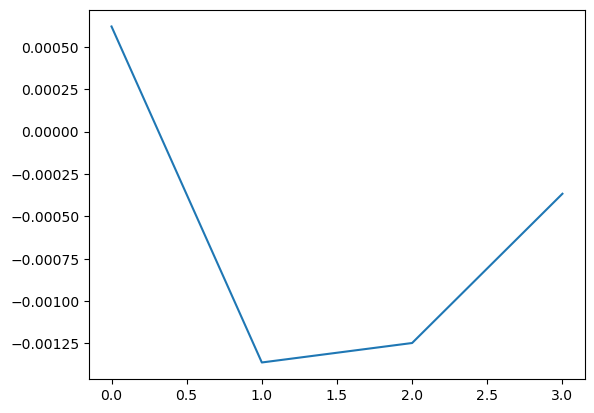

In [12]:
plt.plot(list_vev)

In [8]:
T = [0.1, 0.2, 0.3, 0.4]

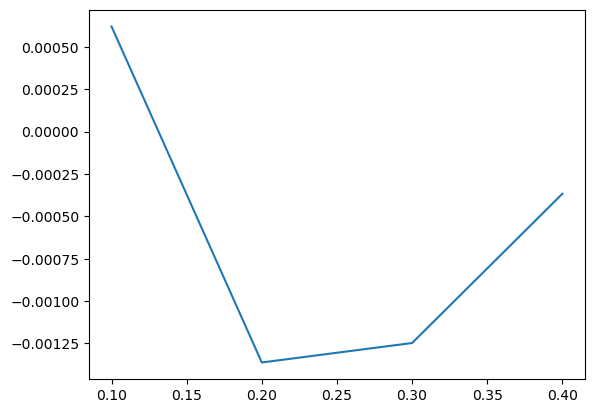

In [9]:
plt.plot(T, list_vev)